In [15]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
from gpflow.utilities import print_summary
import pandas as pd
gpflow.config.set_default_summary_fmt("notebook")
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D
import scipy.ndimage

# The lines below are specific to the notebook format
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot


In [2]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_md_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None, savepath = None):
        self._datapath = datapath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, condition = None, number = None,
                           columns = None,
                           ranges = None, 
                           validation_frac = None):
        
        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (columns == None) or (ranges == None): 
            raise Warning(f'$columns$ and $ranges$ must be given')
        
        if (validation_frac == None):
            warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
            validation_frac = 0.2
    
        all_files = glob.glob(self._datapath + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = []
            df0 = self.get_data_of_a_track(filename = filename, columns = columns,ranges = ranges)
            df1.append(df0)
            
        df = pd.concat(df1, ignore_index=True)
        
        random_state = 1

        if (len(df['type'])*(1 - validation_frac) >= 10000):
            train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        else:
            train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, columns = None, ranges = None):
        '''
        '''        
        one_track = []
        one_track = pd.read_csv(filename)
        
        one_track['frac_age'] = one_track['star_age']/np.max(one_track['star_age'])
        
        #get rid of the pre-MS
        one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        one_track['type'] = 'vali'
        
        for i in range(len(columns)):
            #print(columns[i], ranges[i])
            temp = None
            temp = one_track[(one_track[columns[i]] >= min(ranges[i])) & (one_track[columns[i]] <= max(ranges[i]))]
            if (temp.shape[0] >= 10):
                one_track = one_track.loc[temp.index.min(): temp.index.max()]
            else:
                one_track = None
                break
        
        return one_track
    
    #############################################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    


# global_kernel 
# Here we try GP-3D, says p = f(mass, age, Fe/H) 

# set up path

In [3]:
datadr = '/Users/litz/Documents/GitHub/data/subset_feh_multiple/'
savedr = '/Users/litz/Documents/GitHub/GPflow/3D-teff-test3/'


In [4]:
gmk = global_md_kernel()
gmk.set_path(datapath = datadr, savepath = savedr)


Data path is set as/Users/litz/Documents/GitHub/data/subset_feh_multiple/
Save path is set as/Users/litz/Documents/GitHub/GPflow/3D-teff-test3/


# set up fundimential inputs and observables

In [5]:
fundimential = ['star_mass', 'frac_age','star_age', 'initial_feh']
observable = ['effective_T' , 'log_g']
observable_value = [5777.0, 4.44]
observable_error = [150.0, 0.1]

# 1st we find out the ranges of input and outputs

In [ ]:

columns = ['star_mass', 
           'frac_age',
           'star_age', 
           'initial_feh', 
           'effective_T' , 
           'log_g']
ranges = [[0.9,1.6], 
          [0.0,0.8], 
          [-1.0e99,1.0e99], 
          [-1.0e99,1.0e99], 
          [(5777.0 - 150.0), (5777.0 + 150)],
          [(4.44 - 1.0), (4.44 + 1.0)]
         ]

df = gmk.get_data_of_a_grid(condition = '*.csv', number = 20,
                           columns = columns,
                           ranges = ranges, 
                           validation_frac = 0.3)
df

In [ ]:
#Here we obtained the parameter ranges, note that the frac_age range for all tracks need to be the same for a proper interpolation.  
np.min(df), np.max(df),len(df)


# In test2 we failed to train 3D data derictly (teff = f(m, t, Z)) because the density in 3D space is not good enough. Moreover, we have proved that GP works fairly well for 2D surface. 
# So we change the procedure as follow: 
# 1. GP 2D surface p = f(m,t) for each feh
# 2. Useing these 2D GP models to sample data in 3D space
# 3. Train 3D GP.... 

# we plot Teff-Mass-Age surface of the model grid.  It can be seen that the grid is uniformly spaced.

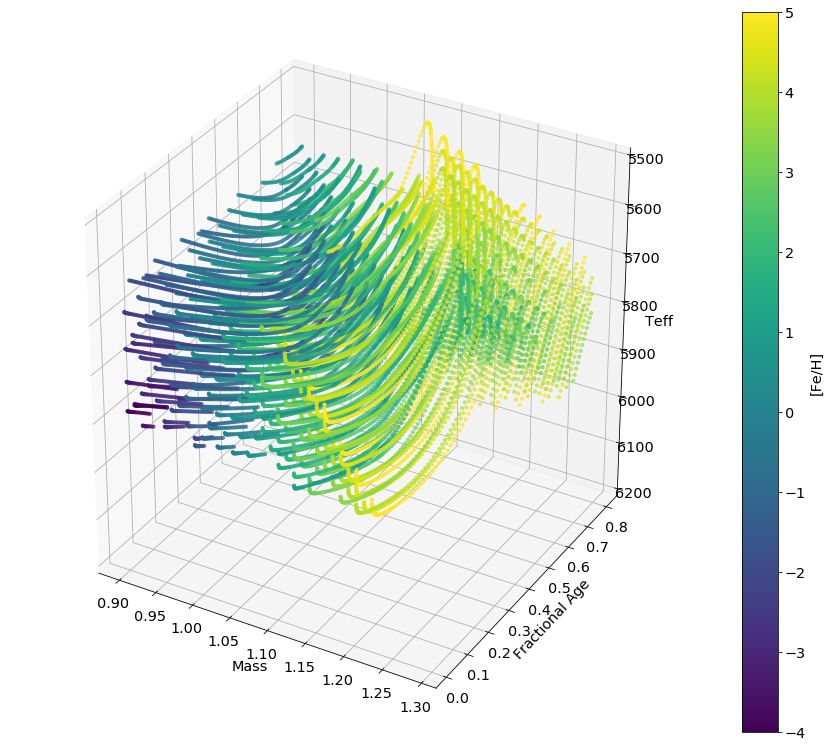

In [117]:
fig = plt.figure()
ax = Axes3D(fig)
cp = ax.scatter(df['star_mass'], df['frac_age'], df['effective_T'],c = df['initial_feh'], s=10)
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Teff')
ax.set_zlim([6200,5500])
char = plt.colorbar(cp)
char.set_label('[Fe/H]')

# step 1: we train the surface (Teff = f(mass, age) ) with 2D GP for each FeH and generate data randomly on each surface. 

In [42]:
def generate_random_3d(xv = None, xf1 = None, xf2 = None, xvstep = None, number = None, factor = None):
    
    new_xv = []
    new_xf1 = []
    new_xf2 = []
    
    if factor == None: factor = 10
        
    number = min([factor*len(xv), number])
    
    for i in range(int(factor)):
        aa = xv + xvstep*(np.random.random(len(xv))-0.5)
        new_xv = np.concatenate((new_xv, aa))
        new_xf1 = np.concatenate((new_xf1, xf1))
        new_xf2 = np.concatenate((new_xf2, xf2))
        if (len(new_xv) >= number): break
    
    idxs = np.random.choice(arange(len(new_xv)), number)
                                   
    return new_xv[idxs], new_xf1[idxs], new_xf2[idxs]

In [92]:
columns = ['star_mass', 
           'frac_age',
           'star_age', 
           'initial_feh', 
           'effective_T' , 
           'log_g']
ranges = [[0.8,1.3], 
          [0.01,0.8], 
          [-1.0e99,1.0e99], 
          [-1.0e99,1.0e99], 
          [(5777.0 - 150.0), (5777.0 + 150)],
          [(4.44 - 1.0), (4.44 + 1.0)]
         ]

fehs = np.linspace(-2.5,2.5,11)

gp1_mass = []
gp1_fage = []
gp1_teff = []
gp1_feh = []

for feh in fehs:
    condition = '*feh' + str(feh) + '*.csv'
    print(condition)
    df = gmk.get_data_of_a_grid(condition = condition, number = None,
                           columns = columns,
                           ranges = ranges, 
                           validation_frac = 0.3)
    
    x1 = df['star_mass'].to_numpy()
    x2 = df['frac_age'].to_numpy()
    x3 = df['initial_feh'].to_numpy()
    z = df['effective_T'].to_numpy().reshape(-1, 1)
    
    print('size of the array for feh = ' + str(feh), z.size)
    
    
    gpflow.config.set_default_positive_minimum(1e-6)
    k = gpflow.kernels.Matern12()
    xx = np.column_stack([[x1, x2]]).T
    
    m_teff = gpflow.models.GPR(data=(xx, z), kernel=k, mean_function=None)

    # optimise hyper-parameters
    opt = gpflow.optimizers.Scipy()

    def objective_closure():
        return - m_teff.log_marginal_likelihood()

    opt_logs = opt.minimize(objective_closure,
                            m_teff.trainable_variables,
                            options=dict(maxiter=1000)
                           )
    
    
    x1_new, x2_new, x3_new = generate_random_3d(x1, x2, x3, 0.01, number = 2000, factor = 2)
    xx_new = np.column_stack([[x1_new, x2_new]]).T
    gpteff, gpteff_var = m_teff.predict_f(xx_new)

    gp1_mass = np.concatenate((gp1_mass, x1_new))
    gp1_fage = np.concatenate((gp1_fage, x2_new))
    gp1_feh = np.concatenate((gp1_feh, x3_new))
    
    gp1_teff = np.concatenate((gp1_teff, gpteff.numpy().reshape(len(gpteff),) ))



*feh-2.5*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: $number$ is missing, all file will be used


size of the array for feh = -2.5 271
*feh-2.0*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = -2.0 802
*feh-1.5*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = -1.5 719
*feh-1.0*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = -1.0 1291
*feh-0.5*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = -0.5 1321
*feh0.0*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = 0.0 1579
*feh0.5*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective

# Step 2:  Let us sample new data with GP 2D models. As it shown below, we have multple surfaces. 

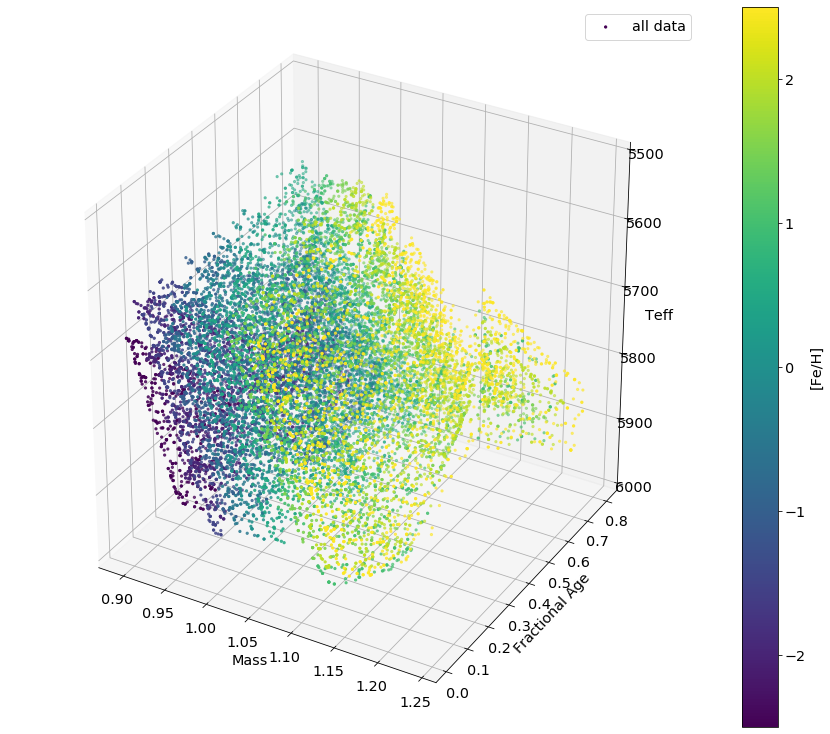

In [93]:
#gp1_mass 
#gp1_fage 
#gp1_teff 
#gp1_feh 
idxs = np.random.choice(arange(len(gp1_mass)), 10000)

x1 = gp1_mass[idxs]
x2 = gp1_fage[idxs]
x3 = gp1_feh[idxs]

z = gp1_teff[idxs]


#gp1_mass = []
#gp1_fage = []
#gp1_teff = []
#gp1_feh = []

fig = plt.figure()
ax = Axes3D(fig)
cp = ax.scatter(gp1_mass, gp1_fage, gp1_teff, s=5, c = gp1_feh, label = 'all data')
#cp = ax.scatter(x1, x2, z, s=5, c = x3, label = 'train set')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Teff')
ax.set_zlim([6000,5500])
char = plt.colorbar(cp)
char.set_label('[Fe/H]')
plt.legend()

# step 3: Now we use the new samples to GP teff = f(mass, age, feh). It takes a couple hours on my laptop

In [94]:
xx = np.column_stack([[x1, x2, x3]]).T
z = z.reshape(-1, 1)
xx.size, x1.size, x2.size, x3.size, z.size

(30000, 10000, 10000, 10000, 10000)

In [95]:
gpflow.config.set_default_positive_minimum(1e-6)
k = gpflow.kernels.Matern12()
    
m2_teff = gpflow.models.GPR(data=(xx, z), kernel=k, mean_function=None)

    # optimise hyper-parameters
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m2_teff.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                            m2_teff.trainable_variables,
                            options=dict(maxiter=100)
                           )

# Model is available, now let us look at GP predictions.

In [96]:
gp2_feh, gp2_mass, gp2_fage = generate_random_3d(xv = gp1_feh, 
                                                 xf1 = gp1_mass, 
                                                 xf2 = gp1_fage, 
                                                 xvstep = 0.5, 
                                                 number = 10000, 
                                                 factor = 1)
print(gp2_feh)

[ 0.168583    1.85626478 -0.16299881 ...  0.30710227  2.38851248
 -0.25672638]


In [97]:
xx_new = np.column_stack([[gp2_mass, gp2_fage, gp2_feh]]).T
gp2_teff, gp2_teff_var = m2_teff.predict_f(xx_new)

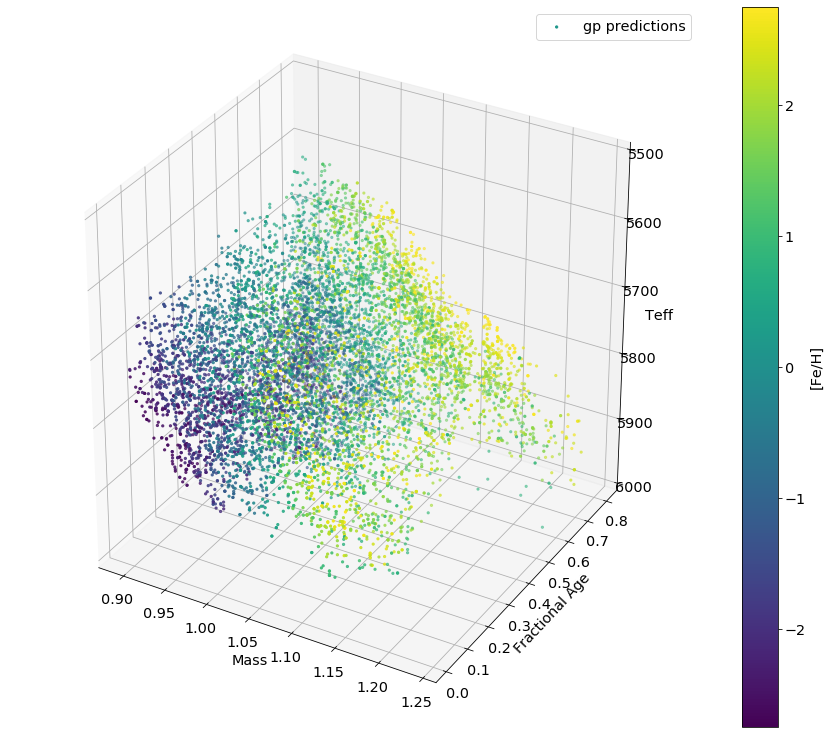

In [98]:
fig = plt.figure()
ax = Axes3D(fig)
cp = ax.scatter(gp2_mass, gp2_fage, gp2_teff, s=5, c = gp2_feh, label = 'gp predictions')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('Teff')
ax.set_zlim([6000,5500])
char = plt.colorbar(cp)
char.set_label('[Fe/H]')
plt.legend()

# GP seems working Okay, but we can not tell the predictions are good or bad. Let us look into the results by comparing GP predictions for several FeHs which are off-grid with inputs data.

# The grid points of FeH are -5 -- +5 with a step of 0.5 dex. Here we use GP to predict Teff for FeH = -1.76, 0.23, and 2.31.

In [99]:
# plot HRD for given [FeH]
fehtest = [-1.76,0.23,2.31] 
tx1_0 = gp1_mass[gp1_feh == -1.5]
tx1_1 = gp1_mass[gp1_feh == 0.0]
tx1_2 = gp1_mass[gp1_feh == 2.5]

tx2_0 = gp1_fage[gp1_feh == -1.5]
tx2_1 = gp1_fage[gp1_feh == 0.0]
tx2_2 = gp1_fage[gp1_feh == 2.5]

tx3_0 = np.full(len(tx1_0), fehtest[0])
tx3_1 = np.full(len(tx1_1), fehtest[1])
tx3_2 = np.full(len(tx1_2), fehtest[2])


xx_new = np.column_stack([[tx1_0, tx2_0, tx3_0]]).T
ty_0, ty_0_var = m2_teff.predict_f(xx_new)

xx_new = np.column_stack([[tx1_1, tx2_1, tx3_1]]).T
ty_1, ty_1_var = m2_teff.predict_f(xx_new)

xx_new = np.column_stack([[tx1_2, tx2_2, tx3_2]]).T
ty_2, ty_2_var = m2_teff.predict_f(xx_new)

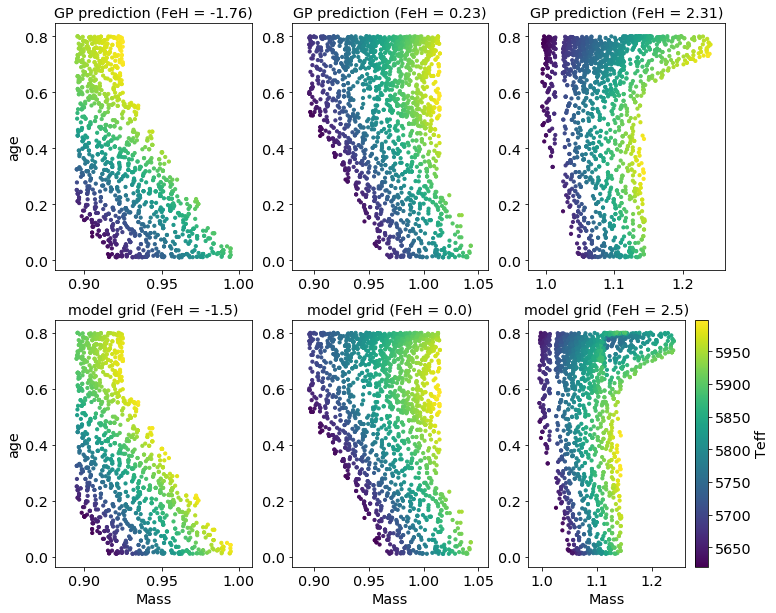

In [100]:

fig, ((ax, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
cp = ax.scatter(tx1_0, tx2_0, c = ty_0.numpy().reshape(len(ty_0),), s = 10)
ax.set_title('GP prediction (FeH = -1.76)')
ax.set_ylabel('age')

cp = ax2.scatter(tx1_1, tx2_1, c = ty_1.numpy().reshape(len(ty_1),), s = 10)
ax2.set_title('GP prediction (FeH = 0.23)')

cp = ax3.scatter(tx1_2, tx2_2, c = ty_2.numpy().reshape(len(ty_2),), s = 10)
ax3.set_title('GP prediction (FeH = 2.31)')

my = gp1_teff[gp1_feh == -1.5]
cp = ax4.scatter(tx1_0, tx2_0, c = my, s = 10)
ax4.set_title('model grid (FeH = -1.5)')
ax4.set_xlabel('Mass')
ax4.set_ylabel('age')

my = gp1_teff[gp1_feh == 0.0]
cp = ax5.scatter(tx1_1, tx2_1, c = my, s = 10)
ax5.set_title('model grid (FeH = 0.0)')
ax5.set_xlabel('Mass')

my = gp1_teff[gp1_feh == 2.5]
cp = ax6.scatter(tx1_2, tx2_2, c = my, s = 10)
ax6.set_title('model grid (FeH = 2.5)')
ax6.set_xlabel('Mass')
char = plt.colorbar(cp)
char.set_label('Teff')

# GP seems to do good job for predicting teff.

# Now let us train logg with the same procedure (it takes another couple hours)

In [77]:
columns = ['star_mass', 
           'frac_age',
           'star_age', 
           'initial_feh', 
           'effective_T' , 
           'log_g']
ranges = [[0.8,1.3], 
          [0.01,0.8], 
          [-1.0e99,1.0e99], 
          [-1.0e99,1.0e99], 
          [(5777.0 - 150.0), (5777.0 + 150)],
          [(4.44 - 1.0), (4.44 + 1.0)]
         ]

fehs = np.linspace(-2.5,2.5,11)

gp1_mass = []
gp1_fage = []
gp1_logg = []
gp1_feh = []

for feh in fehs:
    condition = '*feh' + str(feh) + '*.csv'
    print(condition)
    df = gmk.get_data_of_a_grid(condition = condition, number = None,
                           columns = columns,
                           ranges = ranges, 
                           validation_frac = 0.3)
    
    x1 = df['star_mass'].to_numpy()
    x2 = df['frac_age'].to_numpy()
    x3 = df['initial_feh'].to_numpy()
    z = df['log_g'].to_numpy().reshape(-1, 1)
    
    print('size of the array for feh = ' + str(feh), z.size)
    
    
    gpflow.config.set_default_positive_minimum(1e-6)
    k = gpflow.kernels.Matern12()
    xx = np.column_stack([[x1, x2]]).T
    
    m_logg = gpflow.models.GPR(data=(xx, z), kernel=k, mean_function=None)

    # optimise hyper-parameters
    opt = gpflow.optimizers.Scipy()

    def objective_closure():
        return - m_logg.log_marginal_likelihood()

    opt_logs = opt.minimize(objective_closure,
                            m_logg.trainable_variables,
                            options=dict(maxiter=1000)
                           )
    
    
    x1_new, x2_new, x3_new = generate_random_3d(x1, x2, x3, 0.01, number = 2000, factor = 2)
    xx_new = np.column_stack([[x1_new, x2_new]]).T
    gplogg, gplogg_var = m_logg.predict_f(xx_new)

    gp1_mass = np.concatenate((gp1_mass, x1_new))
    gp1_fage = np.concatenate((gp1_fage, x2_new))
    gp1_feh = np.concatenate((gp1_feh, x3_new))
    
    gp1_logg = np.concatenate((gp1_logg, gplogg.numpy().reshape(len(gplogg),) ))




*feh-2.5*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: $number$ is missing, all file will be used


size of the array for feh = -2.5 271
*feh-2.0*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = -2.0 802
*feh-1.5*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = -1.5 719
*feh-1.0*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = -1.0 1291
*feh-0.5*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = -0.5 1321
*feh0.0*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']
size of the array for feh = 0.0 1579
*feh0.5*.csv
40 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective

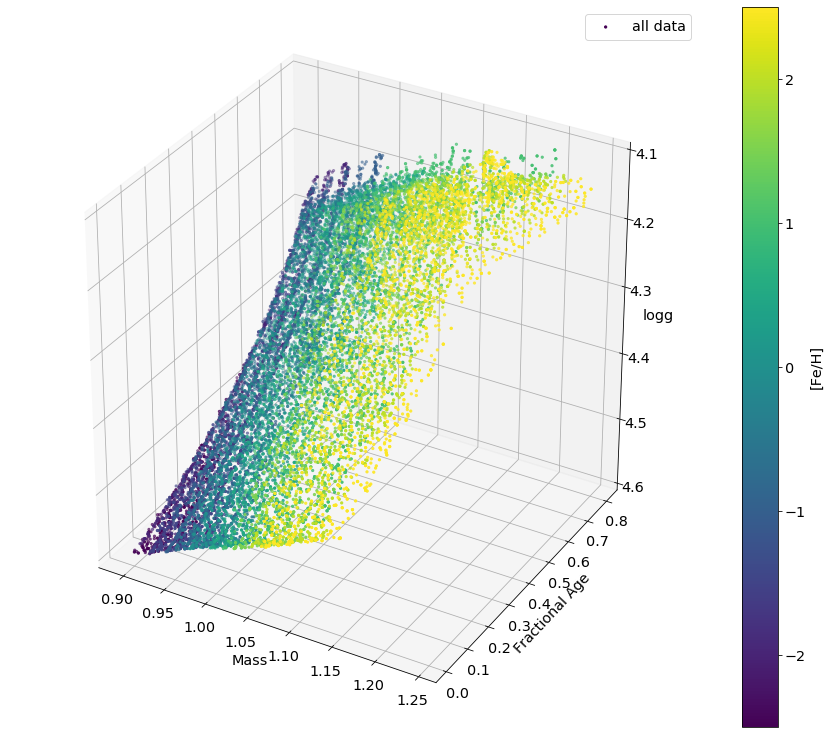

In [81]:
#gp1_mass 
#gp1_fage 
#gp1_teff 
#gp1_feh 
idxs = np.random.choice(arange(len(gp1_mass)), 10000)

x1 = gp1_mass[idxs]
x2 = gp1_fage[idxs]
x3 = gp1_feh[idxs]

z = gp1_logg[idxs]


#gp1_mass = []
#gp1_fage = []
#gp1_teff = []
#gp1_feh = []

fig = plt.figure()
ax = Axes3D(fig)
cp = ax.scatter(gp1_mass, gp1_fage, gp1_logg, s=5, c = gp1_feh, label = 'all data')
#cp = ax.scatter(x1, x2, z, s=5, c = x3, label = 'train set')
ax.set_xlabel('Mass')
ax.set_ylabel('Fractional Age')
ax.set_zlabel('logg')
ax.set_zlim([4.6,4.1])
char = plt.colorbar(cp)
char.set_label('[Fe/H]')
plt.legend()

In [82]:
xx = np.column_stack([[x1, x2, x3]]).T
z = z.reshape(-1, 1)
xx.size, x1.size, x2.size, x3.size, z.size

(30000, 10000, 10000, 10000, 10000)

In [83]:
gpflow.config.set_default_positive_minimum(1e-6)
k = gpflow.kernels.Matern12()
    
m2_logg = gpflow.models.GPR(data=(xx, z), kernel=k, mean_function=None)

    # optimise hyper-parameters
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return - m2_logg.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,
                            m2_logg.trainable_variables,
                            options=dict(maxiter=100)
                           )

[-2.22407932 -1.58261621 -2.23263487 ... -0.36413906 -0.27603464
  0.29392559]


In [122]:
# plot HRD for given [FeH]
fehtest = [-1.76,0.23,2.31] 
tx1_0 = gp1_mass[gp1_feh == -1.5]
tx1_1 = gp1_mass[gp1_feh == 0.0]
tx1_2 = gp1_mass[gp1_feh == 2.5]

tx2_0 = gp1_fage[gp1_feh == -1.5]
tx2_1 = gp1_fage[gp1_feh == 0.0]
tx2_2 = gp1_fage[gp1_feh == 2.5]

tx3_0 = np.full(len(tx1_0), fehtest[0])
tx3_1 = np.full(len(tx1_1), fehtest[1])
tx3_2 = np.full(len(tx1_2), fehtest[2])


xx_new = np.column_stack([[tx1_0, tx2_0, tx3_0]]).T
ty_0, ty_0_var = m2_logg.predict_f(xx_new)

xx_new = np.column_stack([[tx1_1, tx2_1, tx3_1]]).T
ty_1, ty_1_var = m2_logg.predict_f(xx_new)

xx_new = np.column_stack([[tx1_2, tx2_2, tx3_2]]).T
ty_2, ty_2_var = m2_logg.predict_f(xx_new)

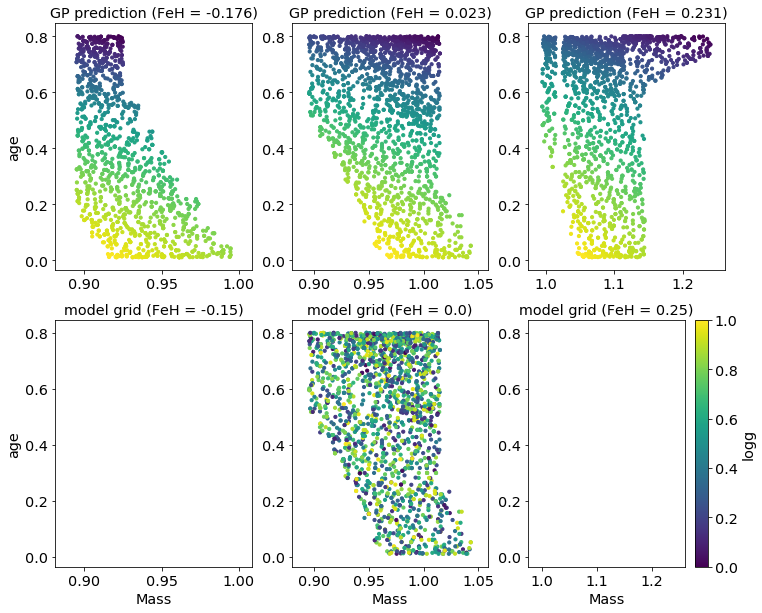

In [123]:
fig, ((ax, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
cp = ax.scatter(tx1_0, tx2_0, c = ty_0.numpy().reshape(len(ty_0),), s = 10)
ax.set_title('GP prediction (FeH = -0.176)')
ax.set_ylabel('age')

cp = ax2.scatter(tx1_1, tx2_1, c = ty_1.numpy().reshape(len(ty_1),), s = 10)
ax2.set_title('GP prediction (FeH = 0.023)')

cp = ax3.scatter(tx1_2, tx2_2, c = ty_2.numpy().reshape(len(ty_2),), s = 10)
ax3.set_title('GP prediction (FeH = 0.231)')

my = gp1_logg[gp1_feh == -0.15]
cp = ax4.scatter(tx1_0, tx2_0, c = my, s = 10)
ax4.set_title('model grid (FeH = -0.15)')
ax4.set_xlabel('Mass')
ax4.set_ylabel('age')

my = gp1_logg[gp1_feh == 0.0]
cp = ax5.scatter(tx1_1, tx2_1, c = my, s = 10)
ax5.set_title('model grid (FeH = 0.0)')
ax5.set_xlabel('Mass')

my = gp1_logg[gp1_feh == 0.25]
cp = ax6.scatter(tx1_2, tx2_2, c = my, s = 10)
ax6.set_title('model grid (FeH = 0.25)')
ax6.set_xlabel('Mass')
char = plt.colorbar(cp)
char.set_label('logg')

# Lastly, we make GP HRDS for off-grid [Fe/H] (-1.76,0.23,2.48) and compare them with original model grid (Fe/H = -1.5, 0.0, 2.5)

In [104]:
columns = ['star_mass', 
           'frac_age',
           'star_age', 
           'initial_feh', 
           'effective_T' , 
           'log_g']
ranges = [[0.8,1.3], 
          [0.01,0.8], 
          [-1.0e99,1.0e99], 
          [-1.0e99,1.0e99], 
          [(5777.0 - 150.0), (5777.0 + 150)],
          [(4.44 - 1.0), (4.44 + 1.0)]
         ]
df = gmk.get_data_of_a_grid(condition = '*.csv', number = None,
                           columns = columns,
                           ranges = ranges, 
                           validation_frac = 0.3)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: $number$ is missing, all file will be used


829 tracks are found
the columns names are['star_mass', 'frac_age', 'star_age', 'initial_feh', 'effective_T', 'log_g']


In [112]:
# plot HRD for given [FeH]
fehtest = [-1.76,0.23,2.48] 
tx1_0 = df['star_mass'][df['initial_feh']==-1.5].to_numpy()
tx1_1 = df['star_mass'][df['initial_feh']==0.0].to_numpy()
tx1_2 = df['star_mass'][df['initial_feh']==2.5].to_numpy()

tx2_0 = df['frac_age'][df['initial_feh']==-1.5].to_numpy()
tx2_1 = df['frac_age'][df['initial_feh']==0.0].to_numpy()
tx2_2 = df['frac_age'][df['initial_feh']==2.5].to_numpy()

tx3_0 = np.full(len(tx1_0), fehtest[0])
tx3_1 = np.full(len(tx1_1), fehtest[1])
tx3_2 = np.full(len(tx1_2), fehtest[2])


xx_new = np.column_stack([[tx1_0, tx2_0, tx3_0]]).T
teff_0, teff_0_var = m2_teff.predict_f(xx_new)
logg_0, logg_0_var = m2_logg.predict_f(xx_new)

xx_new = np.column_stack([[tx1_1, tx2_1, tx3_1]]).T
teff_1, teff_1_var = m2_teff.predict_f(xx_new)
logg_1, logg_1_var = m2_logg.predict_f(xx_new)

xx_new = np.column_stack([[tx1_2, tx2_2, tx3_2]]).T
teff_2, teff_2_var = m2_teff.predict_f(xx_new)
logg_2, logg_2_var = m2_logg.predict_f(xx_new)

Text(0.5, 1.0, 'model grid (FeH = 0.25)')

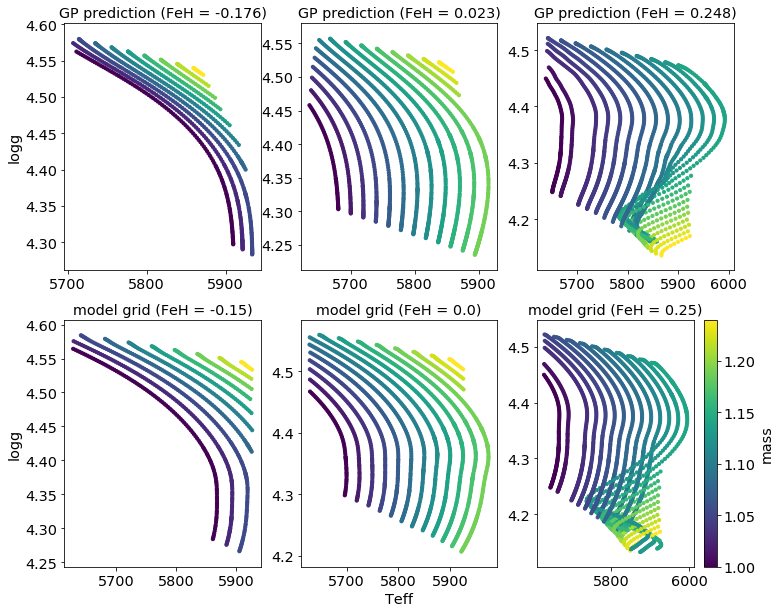

In [118]:
fig, ((ax, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
cp = ax.scatter(teff_0, logg_0, c = tx1_0.reshape(-1,1), s = 10)
ax.set_title('GP prediction (FeH = -0.176)')
ax.set_ylabel('logg')

cp = ax2.scatter(teff_1, logg_1, c = tx1_1.reshape(-1,1), s = 10)
ax2.set_title('GP prediction (FeH = 0.023)')

cp = ax3.scatter(teff_2, logg_2, c = tx1_2.reshape(-1,1), s = 10)
ax3.set_title('GP prediction (FeH = 0.248)')
char = plt.colorbar(cp)
char.set_label('mass')

ax4.scatter(df['effective_T'][df['initial_feh']==-1.5], df['log_g'][df['initial_feh']==-1.5],
           c = df['star_mass'][df['initial_feh']==-1.5], s = 10)
ax4.set_title('model grid (FeH = -0.15)')
ax4.set_ylabel('logg')

ax5.scatter(df['effective_T'][df['initial_feh']==0.0], df['log_g'][df['initial_feh']==0.0],
           c = df['star_mass'][df['initial_feh']==0.0], s = 10)
ax5.set_title('model grid (FeH = 0.0)')
ax5.set_xlabel('Teff')

ax6.scatter(df['effective_T'][df['initial_feh']==2.5], df['log_g'][df['initial_feh']==2.5],
           c = df['star_mass'][df['initial_feh']==2.5], s = 10)
ax6.set_title('model grid (FeH = 0.25)')



# Look! 3D GP models are able to mimic the evolutaionary tracks on HRD.

In [ ]:
# now we generate GP surfaces 